In [15]:
import os
import pandas as pd
import numpy as np



In [16]:
Left_Foot = pd.read_csv(r'C:\SSI_for_consultant\P4\IMU\Quaternion_Sorted\2\Xsens DOT7_D422CD00501C_20231018_170310.csv')
print(Left_Foot)

      PacketCounter  SampleTimeFine    Quat_W    Quat_X    Quat_Y    Quat_Z  \
0                 0      2936795545  0.077191 -0.690340 -0.074776 -0.715457   
1                 1      2936803878  0.077206 -0.690335 -0.074813 -0.715457   
2                 2      2936812211  0.077229 -0.690338 -0.074833 -0.715450   
3                 3      2936820544  0.077251 -0.690341 -0.074861 -0.715441   
4                 4      2936828877  0.077287 -0.690347 -0.074873 -0.715430   
...             ...             ...       ...       ...       ...       ...   
1719           1719      2951119972  0.378587 -0.350623 -0.302105 -0.801540   
1720           1720      2951128305  0.395051 -0.330178 -0.298383 -0.803669   
1721           1721      2951136638  0.411758 -0.308897 -0.294254 -0.805265   
1722           1722      2951144971  0.428747 -0.286907 -0.289812 -0.806144   
1723           1723      2951153304  0.445935 -0.264529 -0.285332 -0.806071   

          Acc_X     Acc_Y     Acc_Z       Gyr_X    

In [17]:
import pandas as pd

def quaternion_conjugate(q):
    w, x, y, z = q
    return (w, -x, -y, -z)

def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2
    z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2
    return (w, x, y, z)

def rotate_vector(quat, vec):
    q_conj = quaternion_conjugate(quat)
    vec_quat = (0, vec[0], vec[1], vec[2])
    temp_quat = quaternion_multiply(quat, vec_quat)
    rotated_vec_quat = quaternion_multiply(temp_quat, q_conj)
    return rotated_vec_quat[1:]

def rotate_acceleration(row):
    quat = (row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z'])
    accel = (row['Acc_X'], row['Acc_Y'], row['Acc_Z'])
    rotated_accel = rotate_vector(quat, accel)
    return pd.Series(rotated_accel, index=['Global_Acc_X', 'Global_Acc_Y', 'Global_Acc_Z'])

# Rotate the accelerations
Left_Foot[['Global_Acc_X', 'Global_Acc_Y', 'Global_Acc_Z']] = Left_Foot.apply(rotate_acceleration, axis=1)

# Define the gravitational constant
gravity_constant = 9.81  # m/s²

# Remove the effect of gravity from the Global Acc Z
Left_Foot['Global_Acc_Z'] = Left_Foot['Global_Acc_Z'] - gravity_constant

# Print the head of the DataFrame to check the results
print(Left_Foot.head())


   PacketCounter  SampleTimeFine    Quat_W    Quat_X    Quat_Y    Quat_Z  \
0              0      2936795545  0.077191 -0.690340 -0.074776 -0.715457   
1              1      2936803878  0.077206 -0.690335 -0.074813 -0.715457   
2              2      2936812211  0.077229 -0.690338 -0.074833 -0.715450   
3              3      2936820544  0.077251 -0.690341 -0.074861 -0.715441   
4              4      2936828877  0.077287 -0.690347 -0.074873 -0.715430   

      Acc_X     Acc_Y     Acc_Z     Gyr_X     Gyr_Y     Gyr_Z Unnamed: 12  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000               
1  9.787352 -0.099881  0.276013  1.087978 -2.202440  0.323572               
2  9.854457 -0.085944  0.301486  1.008983 -2.242552  0.478769               
3  9.858308 -0.096489  0.286715  1.060852 -2.350132  0.488425               
4  9.828652 -0.088662  0.301314  1.051093 -2.294344  0.692929               

   Global_Acc_X  Global_Acc_Y  Global_Acc_Z  
0      0.000000      0.000000     

In [18]:
Left_Foot['time_seconds'] = Left_Foot.index * (1/120)
        
Left_Foot['Acc_X_derivative'] = np.gradient(Left_Foot['Acc_X'], Left_Foot['time_seconds'])

Left_Foot['change_in_gradient'] = np.diff(Left_Foot['Acc_X_derivative'], prepend=Left_Foot['Acc_X_derivative'][0])

threshold = 10
skip_points = 50

mask = np.abs(Left_Foot['change_in_gradient']) > threshold
adjusted_mask = np.zeros_like(mask, dtype=bool)
adjusted_mask[skip_points:] = mask[skip_points:]

time_seconds_high_change = Left_Foot['time_seconds'][adjusted_mask]
acc_z_high_change = Left_Foot['Acc_X'][adjusted_mask]
change_in_gradient_high_change = Left_Foot['change_in_gradient'][adjusted_mask]

first_10_count = 10
time_seconds_first_10 = time_seconds_high_change.head(first_10_count)
acc_z_first_10 = acc_z_high_change.head(first_10_count)
change_in_gradient_first_10 = change_in_gradient_high_change.head(first_10_count)

max_change_index = change_in_gradient_first_10.abs().idxmax()
max_time = time_seconds_first_10.loc[max_change_index]
max_change = change_in_gradient_first_10.loc[max_change_index]
print(f"\nAbsolute maximum change in gradient: {max_change:.2f} at Time: {max_time:.2f} s\n")

Left_Foot = Left_Foot.loc[Left_Foot['time_seconds'] >= max_time].reset_index(drop=True)

Left_Foot['time_seconds'] = Left_Foot.index * (1/120)

Left_Foot = Left_Foot.loc[:, ~Left_Foot.columns.str.contains('^Unnamed')]
Left_Foot = Left_Foot.drop(columns=['PacketCounter', 'SampleTimeFine'], errors='ignore')
print(Left_Foot)

output_file_name = f'FootLeft.csv'


Absolute maximum change in gradient: -333.01 at Time: 5.51 s

        Quat_W    Quat_X    Quat_Y    Quat_Z      Acc_X     Acc_Y     Acc_Z  \
0     0.099574 -0.686159 -0.090963 -0.714840  14.166445  0.216104 -0.432361   
1     0.100188 -0.684380 -0.090348 -0.716535  12.198538 -0.259772 -0.186536   
2     0.100903 -0.682529 -0.089806 -0.718266  10.701797 -0.078799  0.234975   
3     0.101509 -0.680566 -0.089262 -0.720109  11.264307 -0.076245  0.183237   
4     0.102100 -0.678474 -0.088749 -0.722060  10.982158 -0.124518  0.211777   
...        ...       ...       ...       ...        ...       ...       ...   
1058  0.378587 -0.350623 -0.302105 -0.801540  14.840627 -5.137688 -3.805250   
1059  0.395051 -0.330178 -0.298383 -0.803669  14.537919 -5.114662 -4.667649   
1060  0.411758 -0.308897 -0.294254 -0.805265  13.986508 -5.073573 -5.581391   
1061  0.428747 -0.286907 -0.289812 -0.806144  12.906432 -5.123029 -6.299316   
1062  0.445935 -0.264529 -0.285332 -0.806071  11.326852 -5.101679 -6

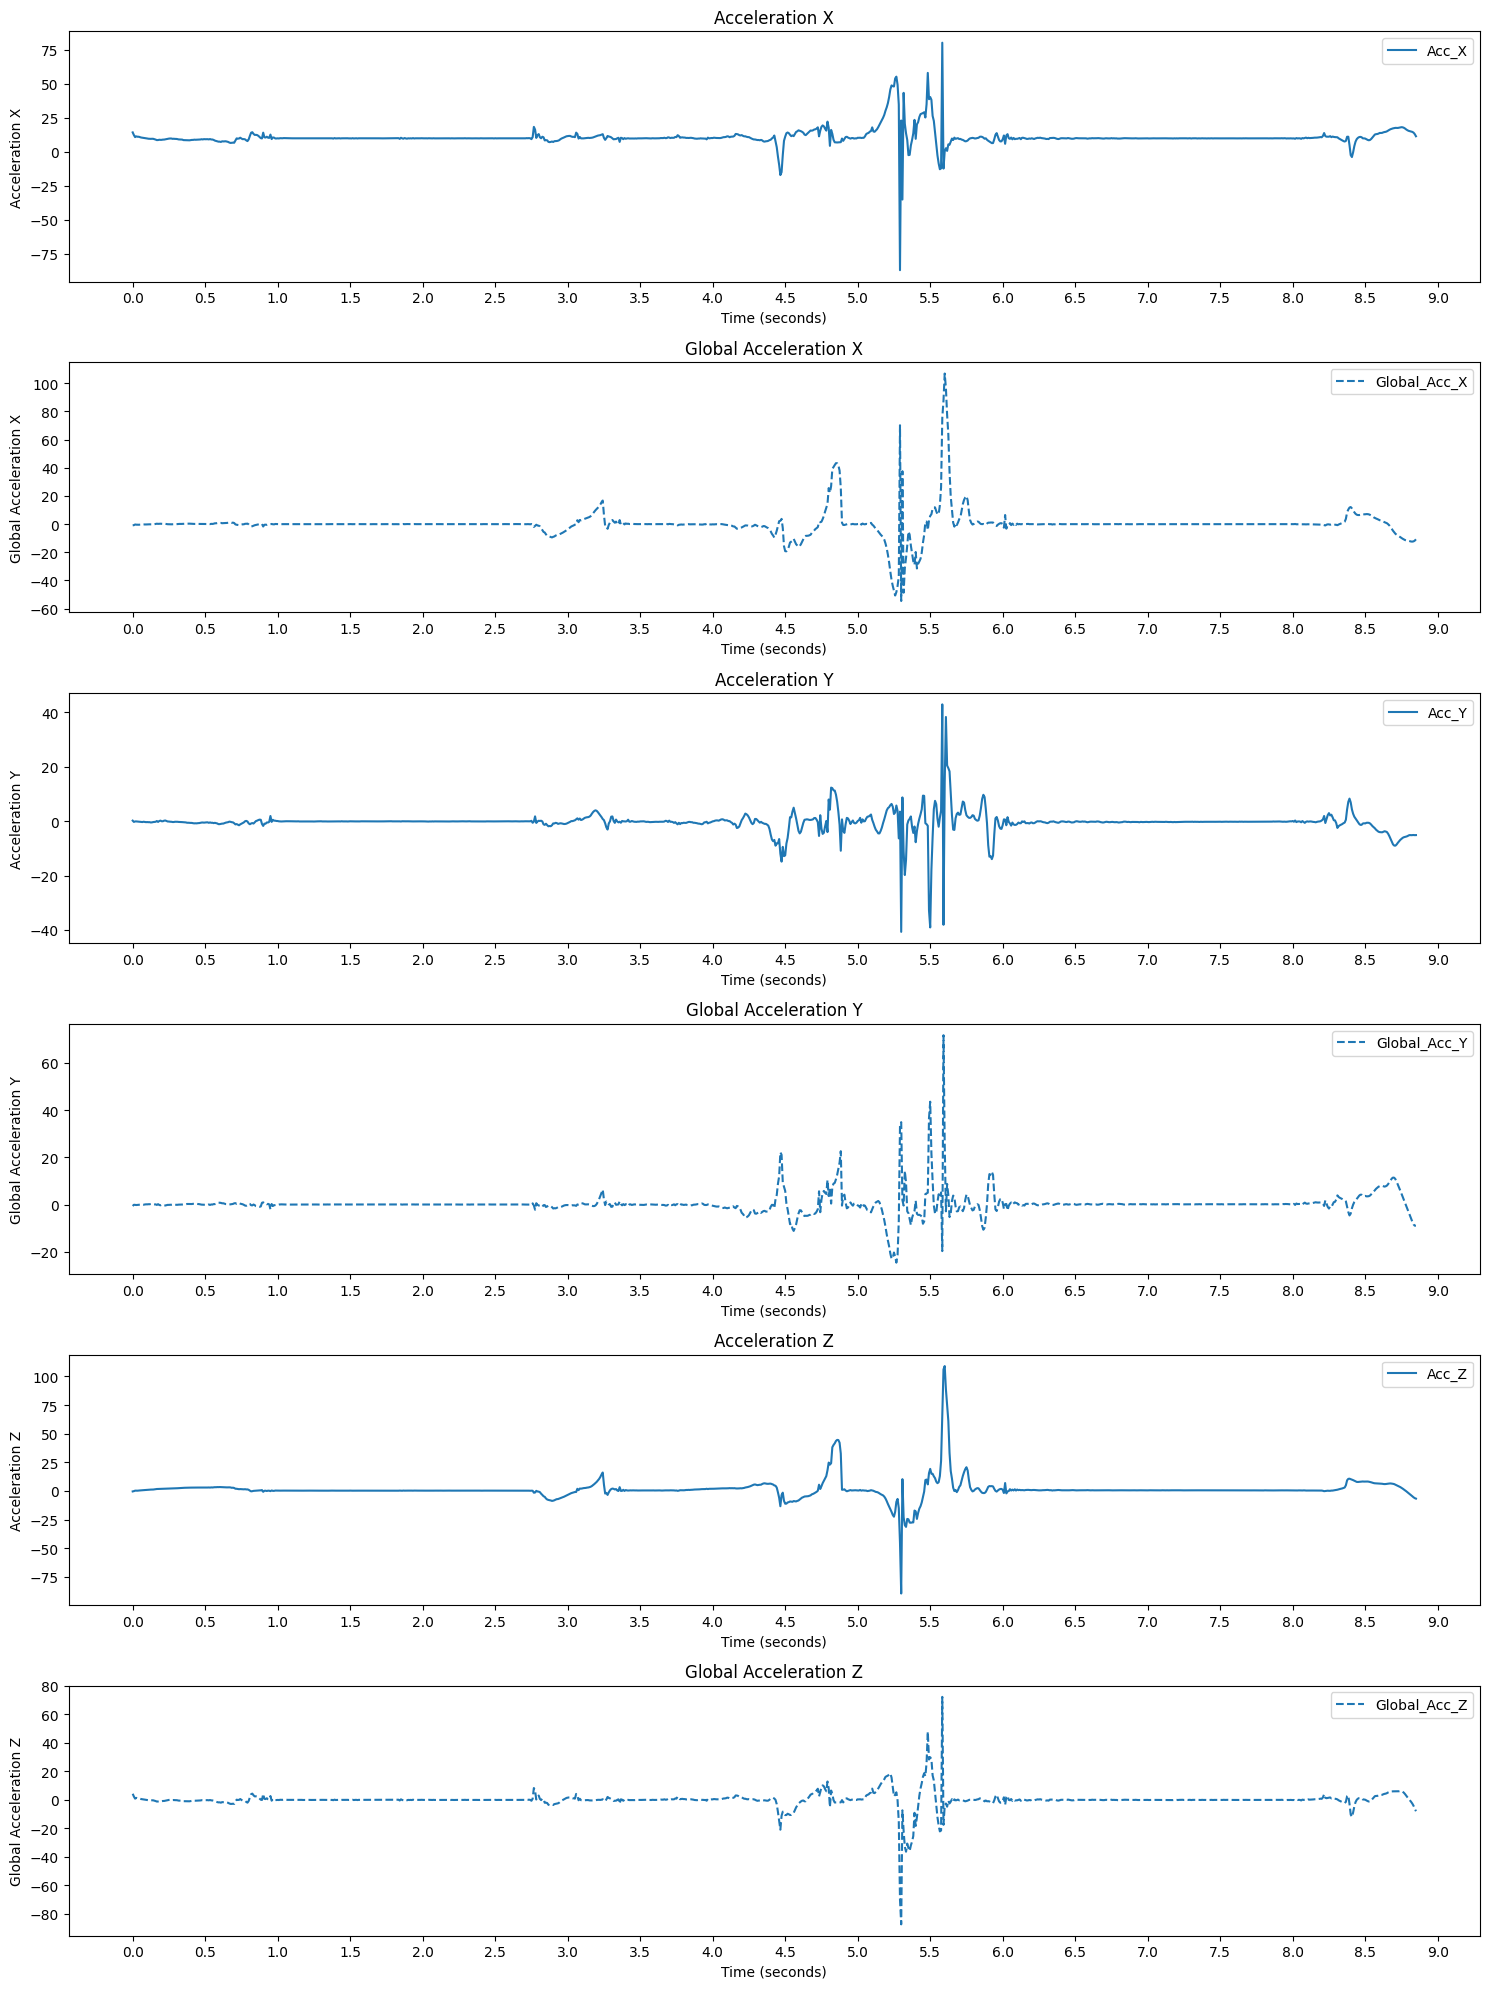

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


fig, axs = plt.subplots(6, 1, figsize=(15, 20))

# Plot Acc_X
axs[0].plot(Left_Foot['time_seconds'], Left_Foot['Acc_X'], label='Acc_X')
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Acceleration X')
axs[0].set_title('Acceleration X')
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs[0].legend()

# Plot Global_Acc_X
axs[1].plot(Left_Foot['time_seconds'], Left_Foot['Global_Acc_X'], label='Global_Acc_X', linestyle='dashed')
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Global Acceleration X')
axs[1].set_title('Global Acceleration X')
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs[1].legend()

# Plot Acc_Y
axs[2].plot(Left_Foot['time_seconds'], Left_Foot['Acc_Y'], label='Acc_Y')
axs[2].set_xlabel('Time (seconds)')
axs[2].set_ylabel('Acceleration Y')
axs[2].set_title('Acceleration Y')
axs[2].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs[2].legend()

# Plot Global_Acc_Y
axs[3].plot(Left_Foot['time_seconds'], Left_Foot['Global_Acc_Y'], label='Global_Acc_Y', linestyle='dashed')
axs[3].set_xlabel('Time (seconds)')
axs[3].set_ylabel('Global Acceleration Y')
axs[3].set_title('Global Acceleration Y')
axs[3].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs[3].legend()

# Plot Acc_Z
axs[4].plot(Left_Foot['time_seconds'], Left_Foot['Acc_Z'], label='Acc_Z')
axs[4].set_xlabel('Time (seconds)')
axs[4].set_ylabel('Acceleration Z')
axs[4].set_title('Acceleration Z')
axs[4].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs[4].legend()

# Plot Global_Acc_Z
axs[5].plot(Left_Foot['time_seconds'], Left_Foot['Global_Acc_Z'], label='Global_Acc_Z', linestyle='dashed')
axs[5].set_xlabel('Time (seconds)')
axs[5].set_ylabel('Global Acceleration Z')
axs[5].set_title('Global Acceleration Z')
axs[5].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs[5].legend()

plt.tight_layout()
plt.show()


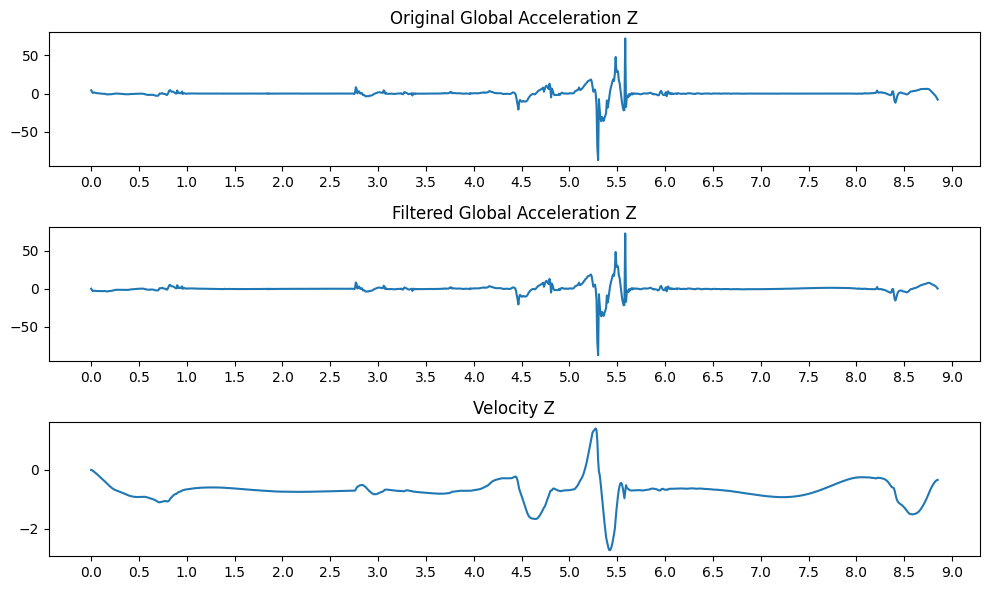

In [20]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.integrate import cumulative_trapezoid as cumtrapz
import matplotlib.pyplot as plt


def highpass_filter(data, cutoff_freq, sample_rate, order=4):
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


cutoff_frequency = 0.3
sample_rate = 60 

Left_Foot['Filtered_Acc_Z'] = highpass_filter(Left_Foot['Global_Acc_Z'], cutoff_frequency, sample_rate)

Left_Foot['Velocity_Z'] = cumtrapz(Left_Foot['Filtered_Acc_Z'], Left_Foot['time_seconds'], initial=0)

plt.figure(figsize=(10, 6))

plt.subplot(311)
plt.plot(Left_Foot['time_seconds'], Left_Foot['Global_Acc_Z'])
plt.title('Original Global Acceleration Z')
plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))

plt.subplot(312)
plt.plot(Left_Foot['time_seconds'], Left_Foot['Filtered_Acc_Z'])
plt.title('Filtered Global Acceleration Z')
plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))

plt.subplot(313)
plt.plot(Left_Foot['time_seconds'], Left_Foot['Velocity_Z'])
plt.title('Velocity Z')
plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))

plt.tight_layout()
plt.show()


In [ ]:
Vicon = pd.read_csv(r'C:\SSI_for_consultant\P4\Vicon\Actual_P4_01.csv')



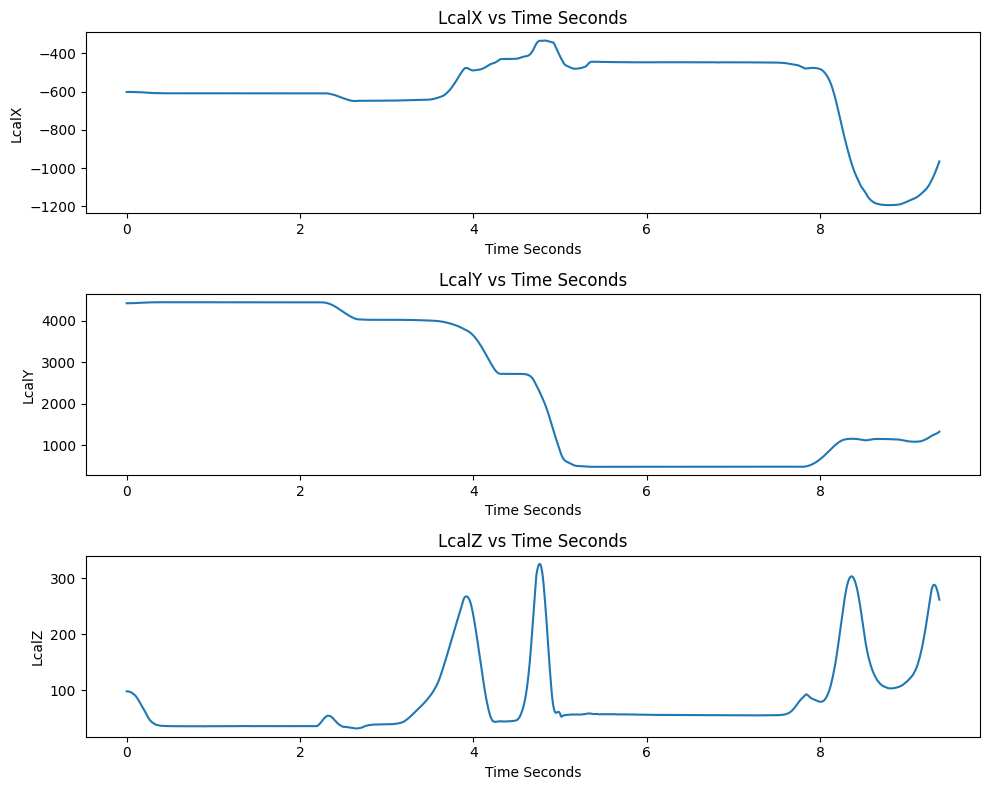

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

Vicon = pd.read_csv(r'C:\SSI_for_consultant\P4\Vicon\Actual_P4_01.csv')

plt.figure(figsize=(10, 8))

plt.subplot(311)
plt.plot(Vicon['time_seconds'], Vicon['LcalX'])
plt.title('LcalX vs Time Seconds')
plt.xlabel('Time Seconds')
plt.ylabel('LcalX')

plt.subplot(312)
plt.plot(Vicon['time_seconds'], Vicon['LcalY'])
plt.title('LcalY vs Time Seconds')
plt.xlabel('Time Seconds')
plt.ylabel('LcalY')


plt.subplot(311)
plt.plot(Left_Foot['time_seconds'], Left_Foot['Global_Acc_Z'])
plt.title('Original Global Acceleration Z')
plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.subplot(313)
plt.plot(Vicon['time_seconds'], Vicon['LcalZ'])
plt.title('LcalZ vs Time Seconds')
plt.xlabel('Time Seconds')
plt.ylabel('LcalZ')

plt.tight_layout()

plt.show()


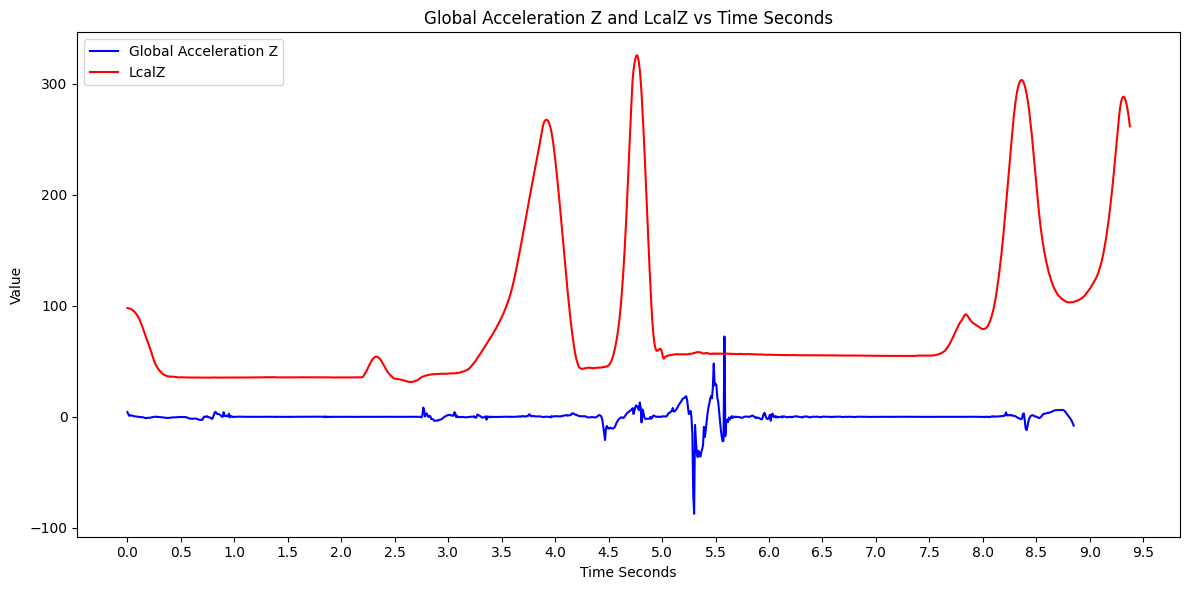

In [23]:

plt.figure(figsize=(12, 6))


plt.plot(Left_Foot['time_seconds'], Left_Foot['Global_Acc_Z'], label='Global Acceleration Z', color='blue')


plt.plot(Vicon['time_seconds'], Vicon['LcalZ'], label='LcalZ', color='red')


plt.title('Global Acceleration Z and LcalZ vs Time Seconds')
plt.xlabel('Time Seconds')
plt.ylabel('Value')
plt.legend()


plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))


plt.tight_layout()
plt.show()

In [25]:
Left_Foot2 = pd.read_csv(r'C:\SSI_for_consultant\P4\IMU\Quaternion_Sorted\2\Xsens DOT7_D422CD00501C_20231018_170310.csv')
print(Left_Foot2)

      PacketCounter  SampleTimeFine    Quat_W    Quat_X    Quat_Y    Quat_Z  \
0                 0      2936795545  0.077191 -0.690340 -0.074776 -0.715457   
1                 1      2936803878  0.077206 -0.690335 -0.074813 -0.715457   
2                 2      2936812211  0.077229 -0.690338 -0.074833 -0.715450   
3                 3      2936820544  0.077251 -0.690341 -0.074861 -0.715441   
4                 4      2936828877  0.077287 -0.690347 -0.074873 -0.715430   
...             ...             ...       ...       ...       ...       ...   
1719           1719      2951119972  0.378587 -0.350623 -0.302105 -0.801540   
1720           1720      2951128305  0.395051 -0.330178 -0.298383 -0.803669   
1721           1721      2951136638  0.411758 -0.308897 -0.294254 -0.805265   
1722           1722      2951144971  0.428747 -0.286907 -0.289812 -0.806144   
1723           1723      2951153304  0.445935 -0.264529 -0.285332 -0.806071   

          Acc_X     Acc_Y     Acc_Z       Gyr_X    

In [27]:
import pandas as pd

def quaternion_conjugate(q):
    w, x, y, z = q
    return (w, -x, -y, -z)

def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2
    z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2
    return (w, x, y, z)

def rotate_vector(quat, vec):
    q_conj = quaternion_conjugate(quat)
    vec_quat = (0, vec[0], vec[1], vec[2])
    temp_quat = quaternion_multiply(quat, vec_quat)
    rotated_vec_quat = quaternion_multiply(temp_quat, q_conj)
    return rotated_vec_quat[1:]

def rotate_acceleration(row):
    quat = (row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z'])
    accel = (row['Acc_X'], row['Acc_Y'], row['Acc_Z'])
    rotated_accel = rotate_vector(quat, accel)
    return pd.Series(rotated_accel, index=['Global_Acc_X', 'Global_Acc_Y', 'Global_Acc_Z'])

Left_Foot2[['Global_Acc_X', 'Global_Acc_Y', 'Global_Acc_Z']] = Left_Foot2.apply(rotate_acceleration, axis=1)

gravity_constant = 9.81  # m/s²

Left_Foot2['Global_Acc_Z'] = Left_Foot2['Global_Acc_Z'] - gravity_constant

print(Left_Foot2)

      PacketCounter  SampleTimeFine    Quat_W    Quat_X    Quat_Y    Quat_Z  \
0                 0      2936795545  0.077191 -0.690340 -0.074776 -0.715457   
1                 1      2936803878  0.077206 -0.690335 -0.074813 -0.715457   
2                 2      2936812211  0.077229 -0.690338 -0.074833 -0.715450   
3                 3      2936820544  0.077251 -0.690341 -0.074861 -0.715441   
4                 4      2936828877  0.077287 -0.690347 -0.074873 -0.715430   
...             ...             ...       ...       ...       ...       ...   
1719           1719      2951119972  0.378587 -0.350623 -0.302105 -0.801540   
1720           1720      2951128305  0.395051 -0.330178 -0.298383 -0.803669   
1721           1721      2951136638  0.411758 -0.308897 -0.294254 -0.805265   
1722           1722      2951144971  0.428747 -0.286907 -0.289812 -0.806144   
1723           1723      2951153304  0.445935 -0.264529 -0.285332 -0.806071   

          Acc_X     Acc_Y     Acc_Z       Gyr_X    

In [29]:
Left_Foot2['time_seconds'] = Left_Foot2.index * (1/120)
print(Left_Foot2)

      PacketCounter  SampleTimeFine    Quat_W    Quat_X    Quat_Y    Quat_Z  \
0                 0      2936795545  0.077191 -0.690340 -0.074776 -0.715457   
1                 1      2936803878  0.077206 -0.690335 -0.074813 -0.715457   
2                 2      2936812211  0.077229 -0.690338 -0.074833 -0.715450   
3                 3      2936820544  0.077251 -0.690341 -0.074861 -0.715441   
4                 4      2936828877  0.077287 -0.690347 -0.074873 -0.715430   
...             ...             ...       ...       ...       ...       ...   
1719           1719      2951119972  0.378587 -0.350623 -0.302105 -0.801540   
1720           1720      2951128305  0.395051 -0.330178 -0.298383 -0.803669   
1721           1721      2951136638  0.411758 -0.308897 -0.294254 -0.805265   
1722           1722      2951144971  0.428747 -0.286907 -0.289812 -0.806144   
1723           1723      2951153304  0.445935 -0.264529 -0.285332 -0.806071   

          Acc_X     Acc_Y     Acc_Z       Gyr_X    

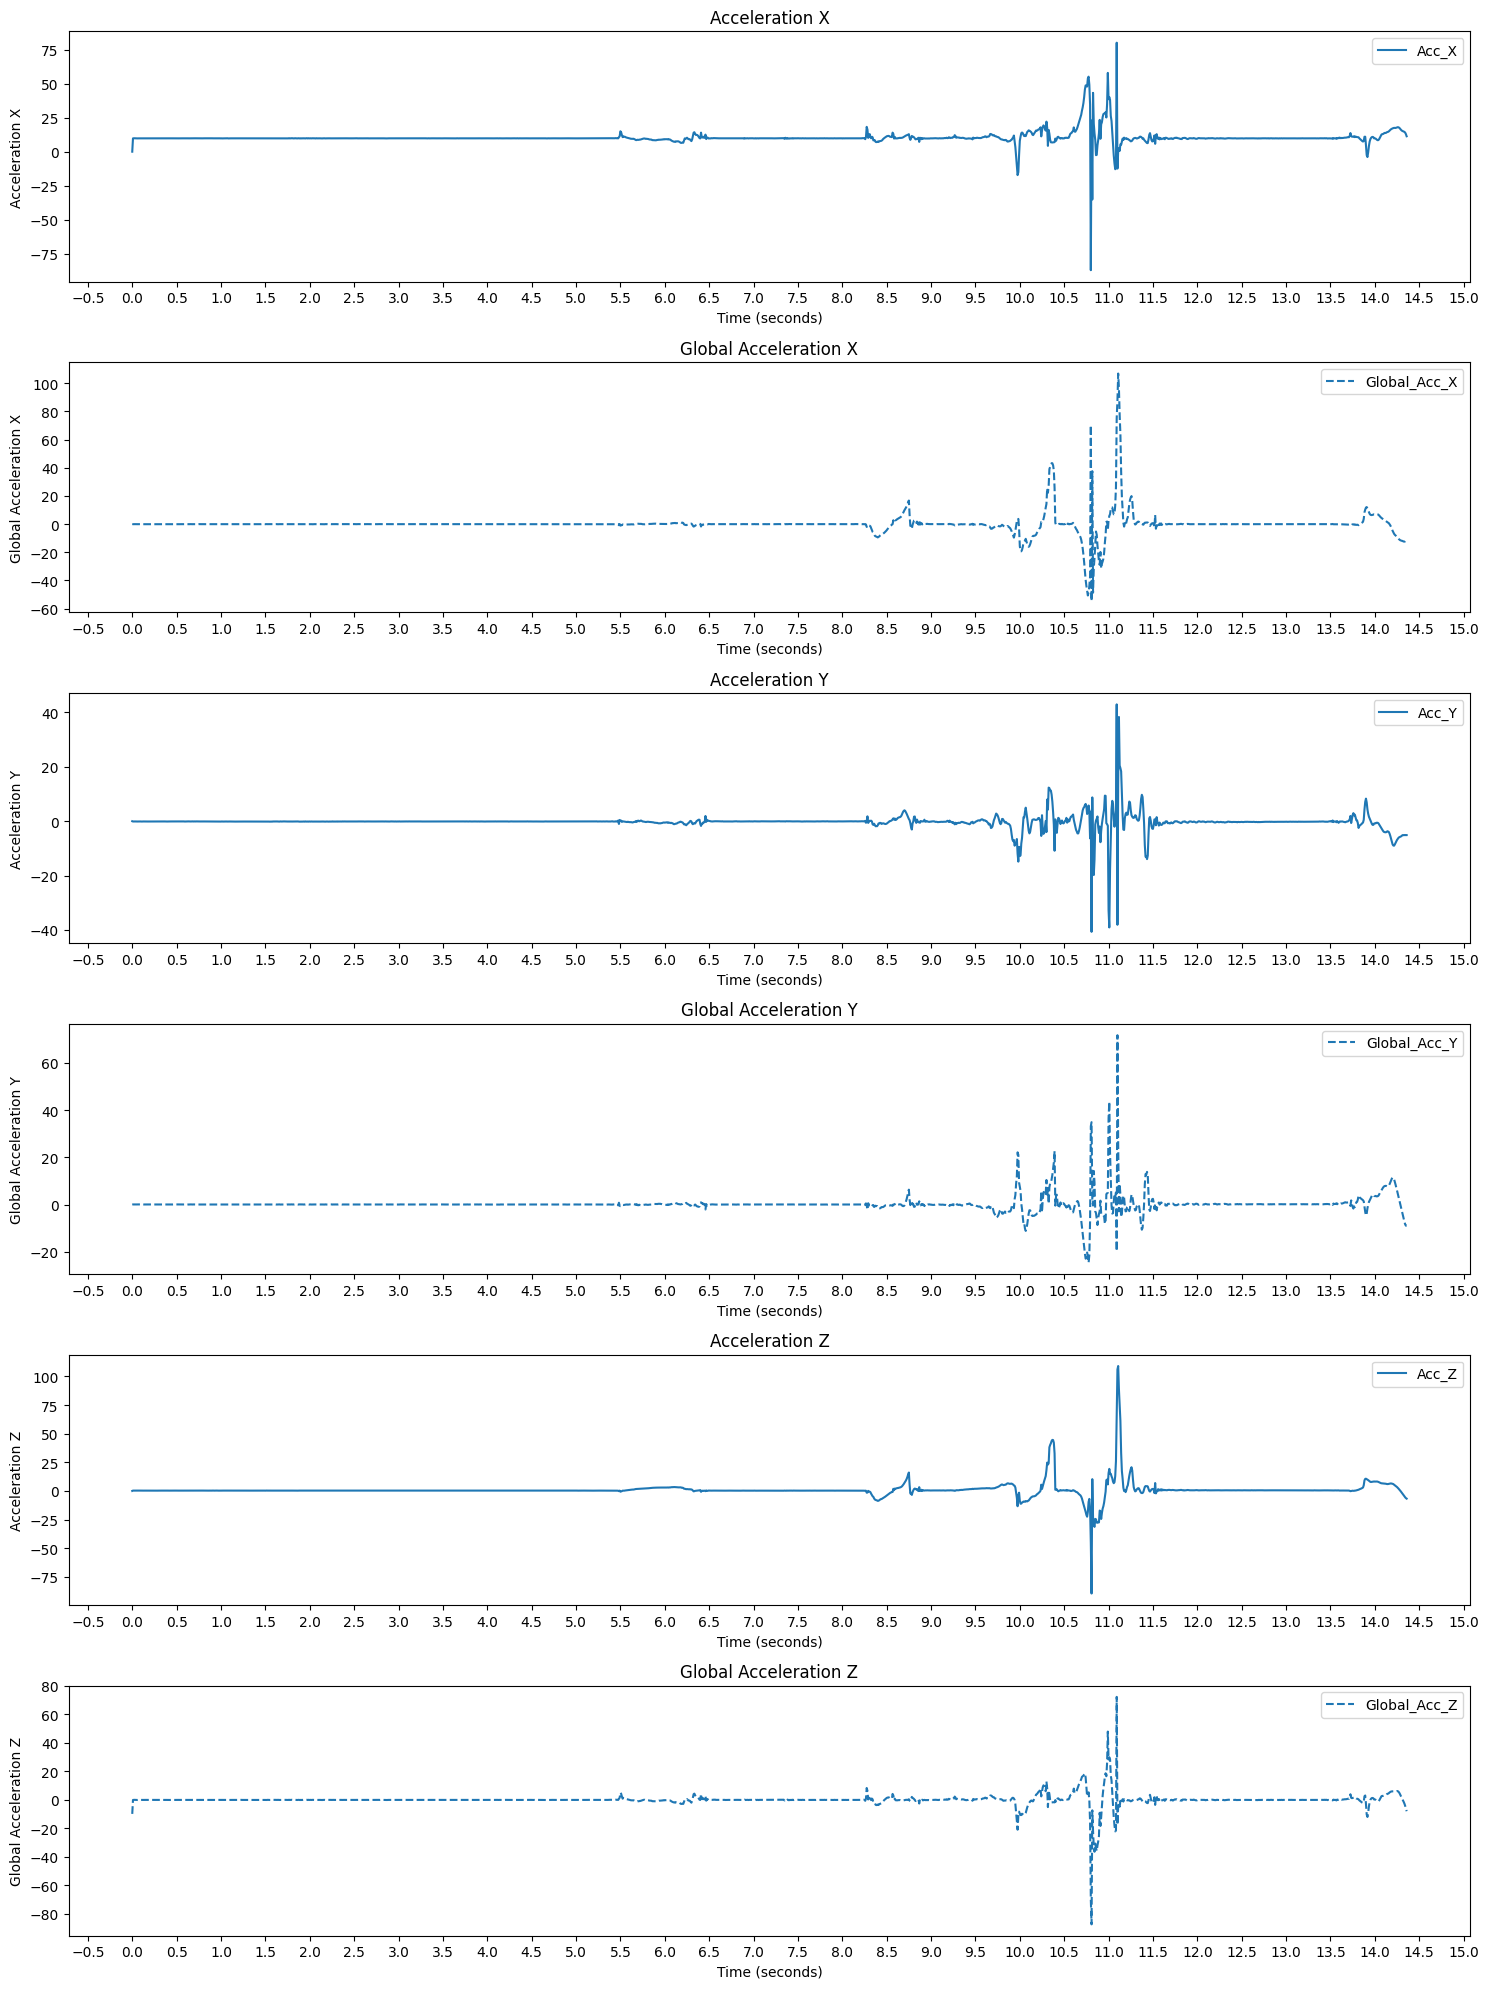

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Plotting the original and rotated acceleration vectors over time_seconds
fig, axs = plt.subplots(6, 1, figsize=(15, 20))

# Plot Acc_X
axs[0].plot(Left_Foot2['time_seconds'], Left_Foot2['Acc_X'], label='Acc_X')
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Acceleration X')
axs[0].set_title('Acceleration X')
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs[0].legend()

# Plot Global_Acc_X
axs[1].plot(Left_Foot2['time_seconds'], Left_Foot2['Global_Acc_X'], label='Global_Acc_X', linestyle='dashed')
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Global Acceleration X')
axs[1].set_title('Global Acceleration X')
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs[1].legend()

# Plot Acc_Y
axs[2].plot(Left_Foot2['time_seconds'], Left_Foot2['Acc_Y'], label='Acc_Y')
axs[2].set_xlabel('Time (seconds)')
axs[2].set_ylabel('Acceleration Y')
axs[2].set_title('Acceleration Y')
axs[2].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs[2].legend()

# Plot Global_Acc_Y
axs[3].plot(Left_Foot2['time_seconds'], Left_Foot2['Global_Acc_Y'], label='Global_Acc_Y', linestyle='dashed')
axs[3].set_xlabel('Time (seconds)')
axs[3].set_ylabel('Global Acceleration Y')
axs[3].set_title('Global Acceleration Y')
axs[3].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs[3].legend()

# Plot Acc_Z
axs[4].plot(Left_Foot2['time_seconds'], Left_Foot2['Acc_Z'], label='Acc_Z')
axs[4].set_xlabel('Time (seconds)')
axs[4].set_ylabel('Acceleration Z')
axs[4].set_title('Acceleration Z')
axs[4].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs[4].legend()

# Plot Global_Acc_Z
axs[5].plot(Left_Foot2['time_seconds'], Left_Foot2['Global_Acc_Z'], label='Global_Acc_Z', linestyle='dashed')
axs[5].set_xlabel('Time (seconds)')
axs[5].set_ylabel('Global Acceleration Z')
axs[5].set_title('Global Acceleration Z')
axs[5].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs[5].legend()

plt.tight_layout()
plt.show()


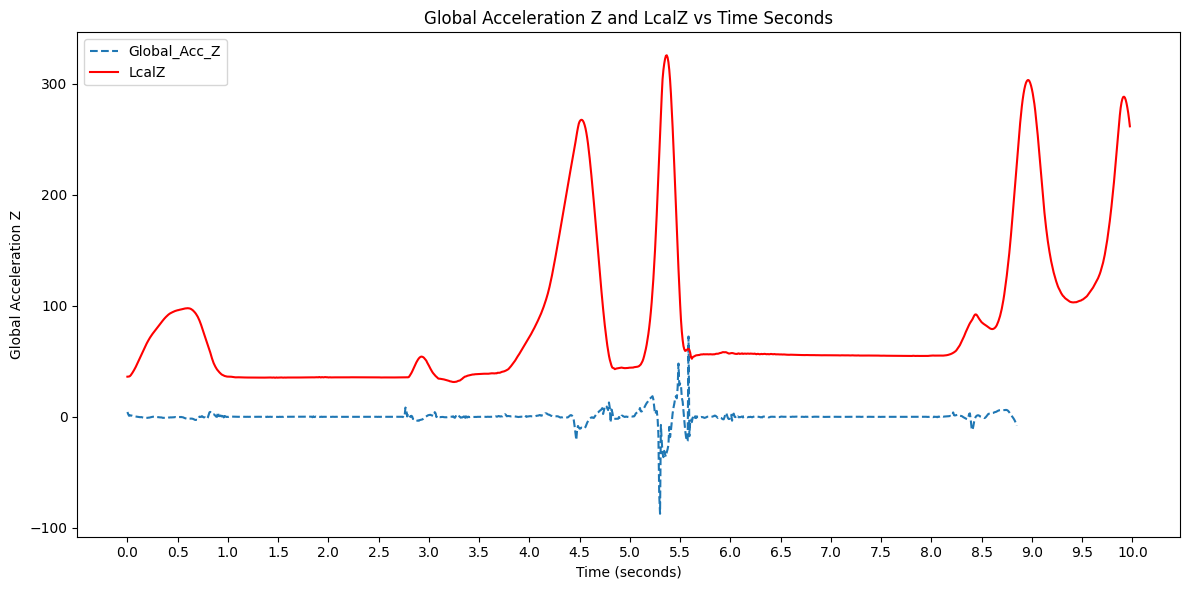

In [35]:
Vicon = pd.read_csv(r'C:\SSI_for_consultant\P4\Vicon\Actual_P4_01.csv')
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

axs.plot(Left_Foot['time_seconds'], Left_Foot['Global_Acc_Z'], label='Global_Acc_Z', linestyle='dashed')
axs.set_xlabel('Time (seconds)')
axs.set_ylabel('Global Acceleration Z')
axs.set_title('Global Acceleration Z and LcalZ vs Time Seconds')
axs.xaxis.set_major_locator(ticker.MultipleLocator(0.5))


axs.plot(Vicon['time_seconds'], Vicon['LcalZ'], label='LcalZ', color='red')

axs.legend()

plt.tight_layout()
plt.show()

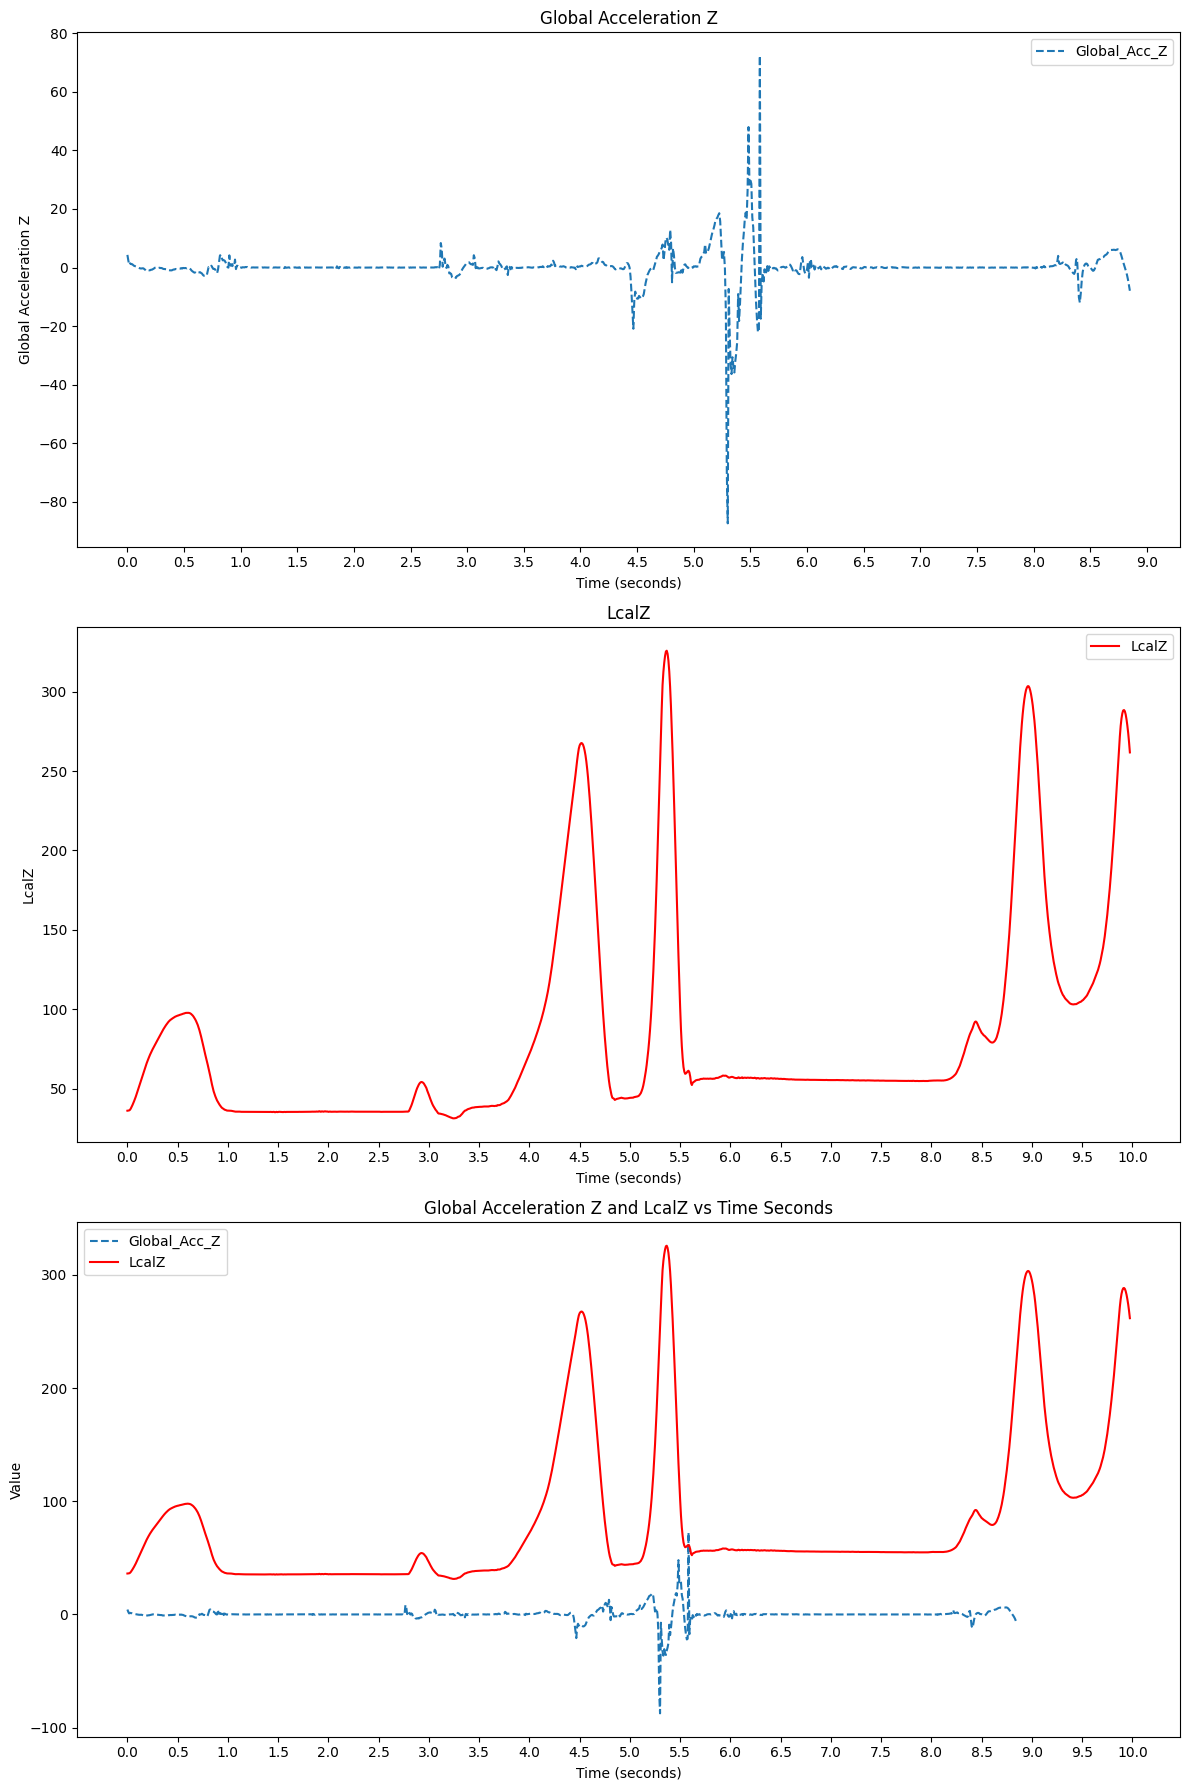

In [36]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))

axs[0].plot(Left_Foot['time_seconds'], Left_Foot['Global_Acc_Z'], label='Global_Acc_Z', linestyle='dashed')
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Global Acceleration Z')
axs[0].set_title('Global Acceleration Z')
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs[0].legend()

axs[1].plot(Vicon['time_seconds'], Vicon['LcalZ'], label='LcalZ', color='red')
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('LcalZ')
axs[1].set_title('LcalZ')
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs[1].legend()

axs[2].plot(Left_Foot['time_seconds'], Left_Foot['Global_Acc_Z'], label='Global_Acc_Z', linestyle='dashed')
axs[2].plot(Vicon['time_seconds'], Vicon['LcalZ'], label='LcalZ', color='red')
axs[2].set_xlabel('Time (seconds)')
axs[2].set_ylabel('Value')
axs[2].set_title('Global Acceleration Z and LcalZ vs Time Seconds')
axs[2].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs[2].legend()

plt.tight_layout()
plt.show()

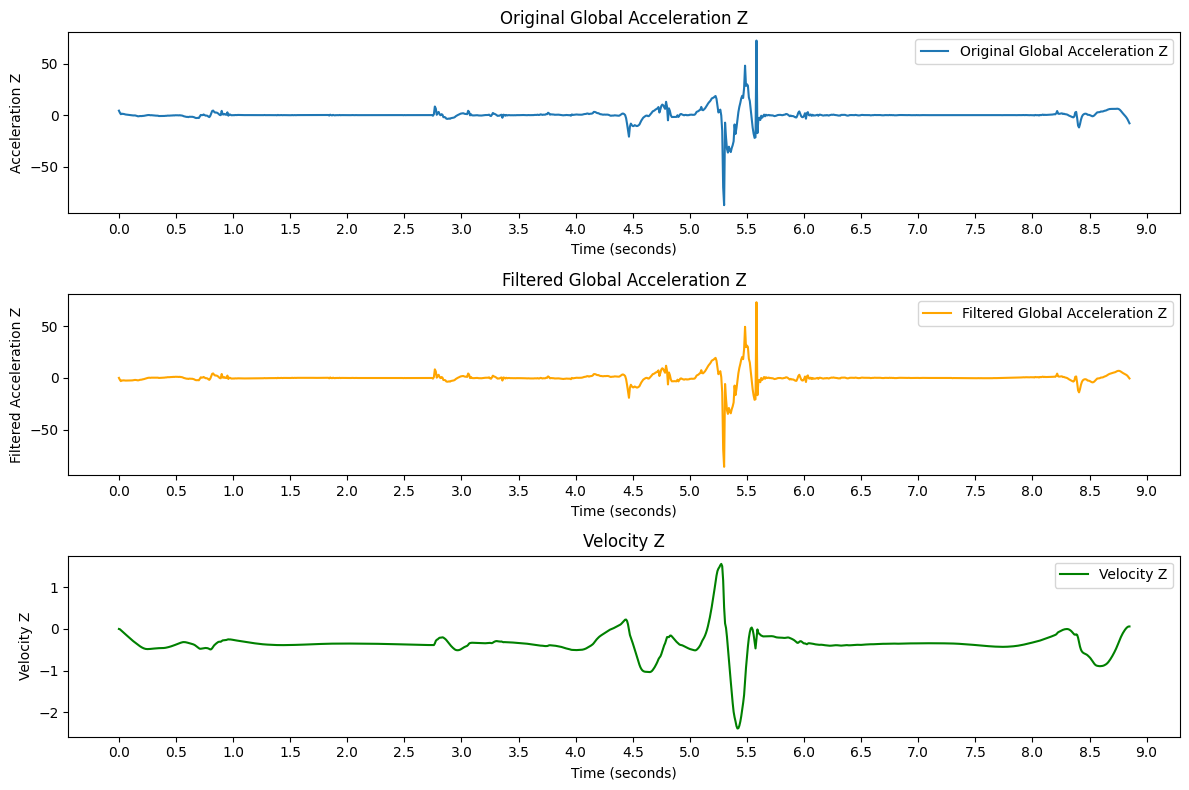

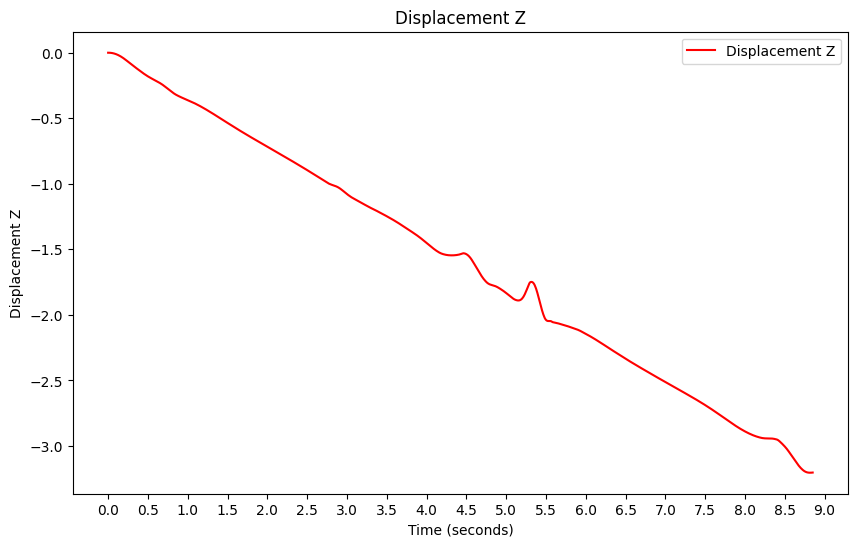

In [39]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.integrate import cumulative_trapezoid as cumtrapz
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def highpass_filter(data, cutoff_freq, sample_rate, order=4):
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

cutoff_frequency = 0.5
sample_rate = 60



Left_Foot['Filtered_Acc_Z'] = highpass_filter(Left_Foot['Global_Acc_Z'], cutoff_frequency, sample_rate)


Left_Foot['Velocity_Z'] = cumtrapz(Left_Foot['Filtered_Acc_Z'], Left_Foot['time_seconds'], initial=0)


Left_Foot['Displacement_Z'] = cumtrapz(Left_Foot['Velocity_Z'], Left_Foot['time_seconds'], initial=0)


plt.figure(figsize=(12, 8))


plt.subplot(311)
plt.plot(Left_Foot['time_seconds'], Left_Foot['Global_Acc_Z'], label='Original Global Acceleration Z')
plt.title('Original Global Acceleration Z')
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration Z')
plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.legend()

plt.subplot(312)
plt.plot(Left_Foot['time_seconds'], Left_Foot['Filtered_Acc_Z'], label='Filtered Global Acceleration Z', color='orange')
plt.title('Filtered Global Acceleration Z')
plt.xlabel('Time (seconds)')
plt.ylabel('Filtered Acceleration Z')
plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.legend()

plt.subplot(313)
plt.plot(Left_Foot['time_seconds'], Left_Foot['Velocity_Z'], label='Velocity Z', color='green')
plt.title('Velocity Z')
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity Z')
plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.legend()


plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(Left_Foot['time_seconds'], Left_Foot['Displacement_Z'], label='Displacement Z', color='red')
plt.title('Displacement Z')
plt.xlabel('Time (seconds)')
plt.ylabel('Displacement Z')
plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.legend()
plt.show()
